# Tornado Synthetic Dataset - 3D Steady
> [cgl datasets](https://cgl.ethz.ch/research/visualization/data.php)

In [1]:
import numpy as np
import pyvista as pv
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
file = '..\\Data\\tornado3d.vti'
mesh = pv.read(file)

## Baseline Streamlines

In [3]:
w,v,u = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

vectors = np.empty((mesh.n_points, 3))
vectors[:,0] = u
vectors[:,1] = v
vectors[:,2] = w

mesh['vectors'] = vectors


In [4]:
# Sphere Source
stream1, seed_pts = mesh.streamlines(
    'vectors', 
    return_source=True,
    n_points=100,
    source_radius=10,
    source_center=(-4e-11,-4e-11,-4e-11),
    # integration_direction='forward'
)

## Compute Streams

In [5]:
def compute_streams(s, seeds, base_mesh):
    '''
        Computes streamlines from seed points and down sample size
    '''
    ws,vs,us = base_mesh.point_data['w'], base_mesh.point_data['v'], base_mesh.point_data['u']

    us.shape = vs.shape = ws.shape = base_mesh.dimensions


    # Down Sample / Decimate
    us = us[::s, ::s, ::s] 
    vs = vs[::s, ::s, ::s]
    ws = ws[::s, ::s, ::s]

    dims = us.shape

    us = us.flatten()
    vs = vs.flatten()
    ws = ws.flatten()

    vectorss = np.empty((int(len(us)), 3))
    vectorss[:,0] = us
    vectorss[:,1] = vs
    vectorss[:,2] = ws

    meshs = pv.UniformGrid(
        dims=dims,
        spacing=tuple([x*s for x in list(base_mesh.spacing)]),
        origin=base_mesh.origin
    )

    meshs['vectorss'] = vectorss
    
    streams = meshs.streamlines_from_source(
        vectors='vectorss', 
        source=seeds
    )
    
    return streams


## Downsampled Streamlines

In [6]:
stream2 = compute_streams(2, seed_pts, mesh)
stream4 = compute_streams(4, seed_pts, mesh)
stream8 = compute_streams(8, seed_pts, mesh)
stream16 = compute_streams(16, seed_pts, mesh)

## Compute Errors

In [18]:
def compute_errors(streams_base, streams_sampled):
    ind_errors = []
    tot_errors = []
    rms_errors = []
    
    for i in range(streams_base.n_cells):
        stream_1 = streams_base.cell_points(i).copy()
        stream_2 = streams_sampled.cell_points(i).copy()
        
        # Distance between each point in streamline
        dv_1 = stream_1[1:,:] - stream_1[:-1,:]
        dv_2 = stream_2[1:,:] - stream_2[:-1,:]
        
        # Length / Magnitude of each delta t
        dl_1 = np.sqrt(np.sum(dv_1**2, axis=1))
        dl_2 = np.sqrt(np.sum(dv_2**2, axis=1))
        
        t1 = np.r_[0, np.cumsum(dl_1)]
        t2 = np.r_[0, np.cumsum(dl_2)]
    
        # Lengths of streamline
        length_1 = t1[-1]
        length_2 = t2[-1]
        
        x1 = interpolate.interp1d(t1, stream_1[:,0])
        y1 = interpolate.interp1d(t1, stream_1[:,1])
        z1 = interpolate.interp1d(t1, stream_1[:,2])
        p1 = lambda t : np.c_[x1(t), y1(t), z1(t)]
        
        x2 = interpolate.interp1d(t2, stream_2[:,0])
        y2 = interpolate.interp1d(t2, stream_2[:,1])
        z2 = interpolate.interp1d(t2, stream_2[:,2])
        p2 = lambda t : np.c_[x2(t), y2(t), z2(t)]
        
        t = np.linspace(0, min(length_1, length_2), 11)    
        ind_error = np.linalg.norm(p1(t) - p2(t), axis=1) # Same as magnitude
        tot_error = np.sum(ind_error)
        rms_error = np.sqrt(np.mean(ind_error**2))

        ind_errors.append(ind_error)
        tot_errors.append(tot_error)
        rms_errors.append(rms_error)
    
    return t, ind_errors, tot_errors, rms_errors

In [20]:
t2, ind_errors2, tot_errors2, rms_errors2 = compute_errors(stream1, stream2)
t4, ind_errors4, tot_errors4, rms_errors4 = compute_errors(stream1, stream4)
# t8, ind_errors8, tot_error8, rms_error8 = compute_errors(stream1, stream8)
# t16, ind_errors16, tot_error16, rms_error16 = compute_errors(stream1, stream16)

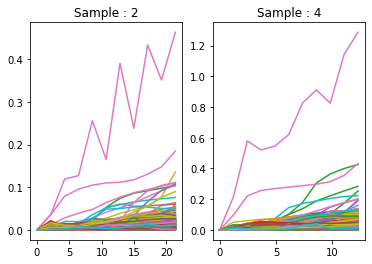

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.set_title('Sample : 2')
ax2.set_title('Sample : 4')

for i in range(len(ind_errors2)):
    ax1.plot(t2, ind_errors2[i], label="error {i}")
    
for i in range(len(ind_errors4)):
    ax2.plot(t4, ind_errors4[i], label="error {i}")
# plt.legend()
plt.show()

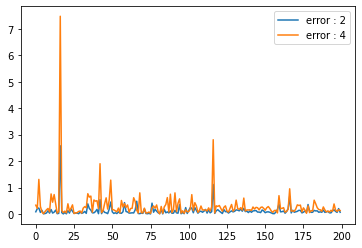

In [22]:
plt.plot(tot_errors2, label='error : 2')
plt.plot(tot_errors4, label='error : 4')
plt.legend()
plt.show()